# Post-stack inversion with proximal solvers - Hess model

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')
import collections

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import segyio

from scipy.signal import filtfilt
from scipy.linalg import solve
from scipy.sparse.linalg import lsqr
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Normalize

from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.utils.wavelets import *
from pylops.avo.poststack import *
from pylops.optimization.sparsity import *
from pylops.basicoperators import VStack as VStacklop


from pyproximal.proximal import *
from pyproximal import ProxOperator
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *
from pyproximal.optimization.bregman import *
from pyproximal.optimization.segmentation import *

from htracker.jointinv import joint_inversion_segmentation
from htracker.workflows import *

np.random.seed(10)

plt.style.use('seaborn-ticks')
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 
plt.rc('font', size=15)
plt.rc('axes', titlesize=15)
plt.rc('axes', labelsize=15)

In [2]:
os.environ['NUMBA_NUM_THREADS'] = '6'

In [3]:
def callback(x, xhist):
    xhist.append(x)

In [4]:
def RRE(x, xinv):
    return np.linalg.norm(x-xinv) / np.linalg.norm(x)

In [5]:
def PSNR(x, xinv):
    return 10 * np.log10(len(xinv) * np.max(xinv)**2 / np.linalg.norm(x-xinv)**2)

In [6]:
rre = {}
psnr = {}

## Hess model

In [7]:
f = segyio.open('../data/timodel_vp.segy', ignore_geometry=True)
v = segyio.collect(f.trace[:]).T
v = np.pad(v, ((80, 0), (0, 0)), constant_values=v[0, 0])
v = v[::8, ::8]

nt0, nx = v.shape
dt0 = 0.008
t0 = np.arange(nt0)*dt0
dx = 4
x = np.arange(nx)*dx

rho = 2000.
m = np.log(v*rho)

Identify classes

In [8]:
collections.Counter(m.ravel())

Counter({16.118093: 9072,
         16.198013: 2313,
         16.360882: 3430,
         16.448978: 7330,
         16.60986: 8021,
         17.203283: 11646,
         16.705547: 6867,
         16.767603: 6344,
         16.853342: 11998,
         16.56278: 140,
         16.922604: 10270,
         16.983343: 12263})

In [9]:
allcl = np.unique(m)
nclmin = 3000 #10000
cl = np.array(list(filter(lambda x: np.count_nonzero(m.ravel() == x) > nclmin, allcl)))
ncl = len(cl)

In [10]:
len(allcl), ncl

(12, 10)

In [11]:
vcl_true = np.zeros_like(m)

for icl in range(ncl):
    vcl_true[m == cl[icl]] = icl

True horizons

In [12]:
hors = {}
for icl in range(ncl-2):
    mclass = (vcl_true == icl).astype(np.int)
    
    cabove = np.zeros(nx)
    cbelow = np.zeros(nx)
    hor = -1 * np.ones(nx)
    for ix in range(nx):
        it = np.where(np.diff(mclass[:, ix]) == -1)[0]
        if len(it) > 0:
            hor[ix] = it[0 if icl==0 else -1] # quick hack
            cabove[ix] = vcl_true[it[0 if icl==0 else -1] - 1, ix]
            cbelow[ix] = vcl_true[it[0 if icl==0 else -1] + 1, ix]
    cabove_sel = sp.stats.mode(cabove)[0]
    cbelow_sel = sp.stats.mode(cbelow)[0]
    
    mask = hor >= 0
    for ix in range(nx):
        if cabove[ix] != cabove_sel or cbelow[ix] != cbelow_sel:
            mask[ix] = False
    hor = np.interp(np.arange(nx), np.arange(nx)[mask], hor[mask])
    hor[~mask] = np.nan
    hors['a%db%d' % (cabove_sel, cbelow_sel)] = hor

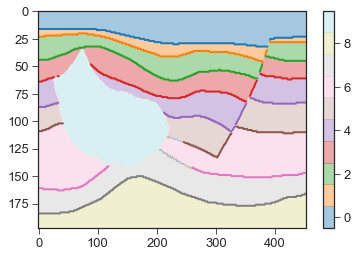

In [13]:
plt.figure()
plt.imshow(vcl_true.reshape(nt0, nx),
           cmap=cm.get_cmap('tab20', ncl), 
           vmin=-0.5, vmax=ncl-0.5, alpha=0.4)
plt.axis('tight')
for icl in list(hors.keys()):
    plt.plot(np.arange(nx), hors[icl], lw=2)
plt.colorbar();

Compute data

In [14]:
# smooth model
nsmooth = 30
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1,
                 filtfilt(np.ones(nsmooth)/float(nsmooth), 1, m, axis=0), axis=1)

# wavelet
ntwav = 61
wav, twav, wavc = ricker(t0[:ntwav//2+1], 8)

# operator
Lop = PoststackLinearModelling(wav / 2, nt0=nt0, spatdims=nx)

# data
d = Lop * m.ravel()

# colored noise
sigman = 1e-1
n = filtfilt(np.ones(10)/10, 1,
             filtfilt(np.ones(5)/5, 1, np.random.normal(0, sigman, (nt0, nx)).T, method='gust').T,
             method='gust').ravel()
dn = d + n

# background data
dback = Lop * mback.ravel()

d = d.reshape(nt0, nx)
dn = dn.reshape(nt0, nx)
dback = dback.reshape(nt0, nx)

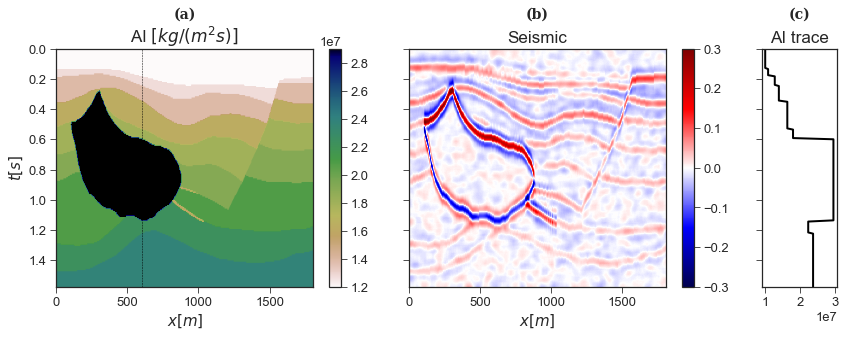

In [15]:
cmap='gist_earth_r'

fig, axs = plt.subplots(1, 3, sharey=True, 
                        gridspec_kw={'width_ratios': [3, 3, 0.7]}, figsize=(12, 5))
im = axs[0].imshow(np.exp(m), vmin=1.2e7, vmax=2.9e7,
                   cmap=cmap, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[0].axvline(x[nx//3], c='k', ls='--', lw=0.5)
axs[0].text(0.5, 1.13, '(a)', ha='center', fontsize=14, fontweight='bold', 
            family='serif', transform=axs[0].transAxes)
plt.colorbar(im, ax=axs[0])
axs[0].axis('tight')
axs[0].set_ylabel(r'$t [s]$')
axs[0].set_xlabel(r'$x [m]$')
axs[0].set_title(r'AI $[kg/(m^2s)]$', fontsize=17)
im = axs[1].imshow(dn, cmap='seismic', vmin=-0.3, vmax=0.3, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1].set_xlabel(r'$x [m]$')
axs[1].set_title('Seismic', fontsize=17)
axs[1].text(0.5, 1.13, '(b)', ha='center', fontsize=14, fontweight='bold', 
            family='serif', transform=axs[1].transAxes)
axs[1].axis('tight')
plt.colorbar(im, ax=axs[1])
axs[2].plot(np.exp(m[:, nx//3]), t0, 'k', lw=2)
axs[2].axis('tight')
axs[2].set_title('AI trace', fontsize=17)
axs[2].text(0.5, 1.13, '(c)', ha='center', fontsize=14, fontweight='bold', 
            family='serif', transform=axs[2].transAxes)
plt.tight_layout()
plt.savefig('Figs/Hess_modeldata.eps', dpi=80);

## 2D Post-stack inversion

In [16]:
# L2 regularized inversion
Dop = Laplacian(dims=(nt0, nx), dtype=Lop.dtype)
minv = RegularizedInversion(Lop, [Dop], dn.ravel(),
                            x0=mback.ravel(), epsRs=[2.], returninfo=False, show=False,
                            **dict(iter_lim=100, damp=1e-4))
dinv = Lop*minv

minv = minv.reshape(nt0, nx)
dinv = dinv.reshape(nt0, nx)

rre['L2'] = RRE(m.ravel(), minv.ravel())
psnr['L2'] = PSNR(m.ravel(), minv.ravel())
print('RRE=', rre['L2'])
print('PSNR=', psnr['L2'])

RRE= 0.0029450326100642753
PSNR= 50.87825819107283


In [17]:
# SplitBregman (Blockiness-promoting inversion with anisotropic TV)
RegL1op = Gradient(dims=(nt0, nx), edge=True, dtype=Lop.dtype, kind='forward')
msb = SplitBregman(Lop, [RegL1op], dn.ravel(),
                   epsRL1s=[0.03], mu=0.3,
                   niter_outer=5,
                   niter_inner=10,
                   x0=mback.ravel(), show=True,
                   **dict(iter_lim=5, damp=1e-4))[0]
dinv = Lop*msb

msb = msb.reshape(nt0, nx)
dinv = dinv.reshape(nt0, nx)

rre['SB'] = RRE(m.ravel(), msb.ravel())
psnr['SB'] = PSNR(m.ravel(), msb.ravel())
print('RRE=', rre['SB'])
print('PSNR=', psnr['SB'])

Split-Bregman optimization
---------------------------------------------------------
The Operator Op has 89694 rows and 89694 cols
niter_outer =   5     niter_inner =  10   tol = 1.00e-10
mu = 3.00e-01         epsL1 = [0.03]	  epsL2 = None     
---------------------------------------------------------

   Itn          x[0]           r2norm          r12norm
     1   1.61647e+01        3.163e-01        1.342e+03
     2   1.61653e+01        3.252e-01        1.194e+03
     3   1.61606e+01        3.437e-01        1.120e+03
     4   1.61627e+01        3.608e-01        1.074e+03
     5   1.61721e+01        3.737e-01        1.039e+03

Iterations = 5        Total time (s) = 2.76
---------------------------------------------------------

RRE= 0.0023869435000045524
PSNR= 52.69584248896833


In [18]:
# L-ADMM (Blockiness-promoting inversion with isotropic TV)
Dop = Gradient(dims=(nt0, nx), edge=True, dtype=Lop.dtype, kind='forward')

sigma=0.04
l1 = L21(ndim=2, sigma=sigma)
l2 = L2(Op=Lop, b=dn.ravel(), niter=10, warm=True)

# steps
L = 8. #np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = 0.99 * tau / L # optimal mu<=tau/maxeig(Dop^H Dop)

mladmm = LinearizedADMM(l2, l1, Dop, tau=tau, mu=mu, x0=mback.ravel(), niter=100, show=True)[0]
dinv = Lop*mladmm

mladmm = mladmm.reshape(nt0, nx)
dinv = dinv.reshape(nt0, nx)

rre['LADMM'] = RRE(m.ravel(), mladmm.ravel())
psnr['LADMM'] = PSNR(m.ravel(), mladmm.ravel())
print('RRE=', rre['LADMM'])
print('PSNR=', psnr['LADMM'])

Linearized-ADMM
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
tau = 1.000000e+00	mu = 1.237500e-01	niter = 100

   Itn       x[0]          f           g       J = f + g
     1   1.61181e+01   5.059e+01   2.122e+01   7.181e+01
     2   1.61194e+01   4.068e+01   2.192e+01   6.260e+01
     3   1.61215e+01   3.373e+01   2.273e+01   5.646e+01
     4   1.61244e+01   2.856e+01   2.351e+01   5.207e+01
     5   1.61278e+01   2.462e+01   2.422e+01   4.884e+01
     6   1.61315e+01   2.162e+01   2.479e+01   4.640e+01
     7   1.61351e+01   1.929e+01   2.526e+01   4.455e+01
     8   1.61382e+01   1.746e+01   2.565e+01   4.311e+01
     9   1.61408e+01   1.600e+01   2.595e+01   4.194e+01
    10   1.61430e+01   1.480e+01   2.616e+01   4.095e+01
    11   1.61450e+01   1.380e+01   2.630e+01   4.010e+01
    2

In [19]:
# Primal-dual (Blockiness-promoting inversion with isotropic TV)
sigma = 0.01
l1 = L21(ndim=2, sigma=sigma)
l2 = L2(Op=Lop, b=dn.ravel(), niter=20, warm=True)
Dop = Gradient(dims=(nt0, nx), edge=True, dtype=Lop.dtype, kind='forward')

L = 8. # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = 0.99 / (tau * L)

mpd = PrimalDual(l2, l1, Dop, mback.ravel(), tau=tau, mu=mu, 
                 theta=1., niter=100, show=True)
dinv = Lop*mpd

mpd = mpd.reshape(nt0, nx)
dinv = dinv.reshape(nt0, nx)

rre['PD'] = RRE(m.ravel(), mpd.ravel())
psnr['PD'] = PSNR(m.ravel(), mpd.ravel())
print('RRE=', rre['PD'])
print('PSNR=', psnr['PD'])

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
Additional vector (z): None
tau = 1.000000e+00	mu = 1.237500e-01
theta = 1.00		niter = 100

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   1.61196e+01   1.914e+01   6.993e+00   0.000e+00       2.614e+01
     2   1.61259e+01   9.430e+00   8.270e+00   0.000e+00       1.770e+01
     3   1.61337e+01   6.373e+00   8.728e+00   0.000e+00       1.510e+01
     4   1.61418e+01   5.003e+00   8.837e+00   0.000e+00       1.384e+01
     5   1.61492e+01   4.239e+00   8.808e+00   0.000e+00       1.305e+01
     6   1.61555e+01   3.757e+00   8.726e+00   0.000e+00       1.248e+01
     7   1.61605e+01   3.426e+00   8.654e+00   0.000e+00       1.208e+01
     8   1.61642e+01   3.186e+00   8

In [20]:
pd.Series(psnr)

L2       50.878258
SB       52.695842
LADMM    52.382553
PD       54.095559
dtype: float64

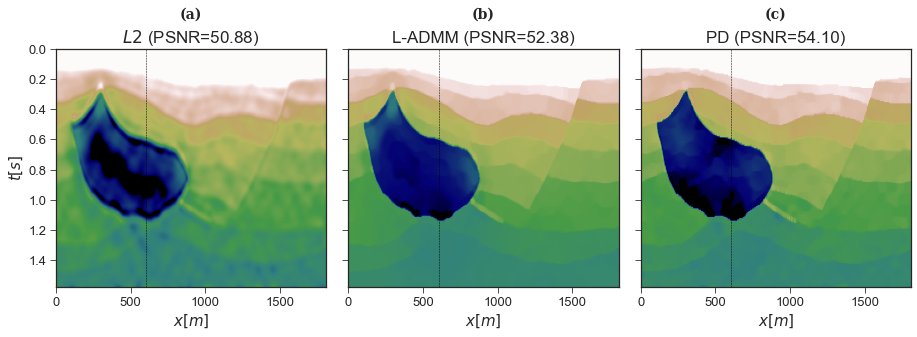

In [21]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(13, 5))
axs[0].imshow(np.exp(minv), vmin=1.2e7, vmax=2.9e7,
                   cmap='gist_earth_r', extent=(x[0], x[-1], t0[-1], t0[0]))
axs[0].axvline(x[nx//3], c='k', ls='--', lw=0.5)
axs[0].set_ylabel(r'$t [s]$')
axs[0].set_xlabel(r'$x [m]$')
axs[0].set_title(r'$L2$ (PSNR=%.2f)' % psnr['L2'], fontsize=17)
axs[0].text(0.5, 1.13, '(a)', ha='center', fontsize=14, fontweight='bold', 
            family='serif', transform=axs[0].transAxes)
axs[0].axis('tight')
axs[1].imshow(np.exp(mladmm), vmin=1.2e7, vmax=2.9e7,
              cmap='gist_earth_r', extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1].axvline(x[nx//3], c='k', ls='--', lw=0.5)
axs[1].set_xlabel(r'$x [m]$')
axs[1].set_title('L-ADMM (PSNR=%.2f)' % psnr['LADMM'], fontsize=17)
axs[1].text(0.5, 1.13, '(b)', ha='center', fontsize=14, fontweight='bold', 
            family='serif', transform=axs[1].transAxes)
axs[1].axis('tight')
axs[2].imshow(np.exp(mpd), vmin=1.2e7, vmax=2.9e7,
              cmap='gist_earth_r', extent=(x[0], x[-1], t0[-1], t0[0]))
axs[2].axvline(x[nx//3], c='k', ls='--', lw=0.5)
axs[2].set_xlabel(r'$x [m]$')
axs[2].set_title('PD (PSNR=%.2f)' % psnr['PD'], fontsize=17)
axs[2].text(0.5, 1.13, '(c)', ha='center', fontsize=14, fontweight='bold', 
            family='serif', transform=axs[2].transAxes)
axs[2].axis('tight')
plt.tight_layout()
plt.savefig('Figs/Hess_inversions.eps', dpi=80);

## 2D Post-stack segmentation

Let's start by taking one of our previous inversion results and use it as input to a segmentation algorithm

In [22]:
segls, segls_classes = \
    Segment(minv, cl, 20., 0.2, niter=50, show=True, 
            kwargs_simplex=dict(engine='numba',  maxiter=10, call=False))

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.Simplex._Simplex_numba'>
Proximal operator (g): <class 'pyproximal.proximal.VStack.VStack'>
Linear operator (A): <class 'pylops.basicoperators.BlockDiag.BlockDiag'>
Additional vector (z): vector
tau = 1.000000e+00	mu = 1.250000e-01
theta = 1.00		niter = 50

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   7.33774e-01   0.000e+00   5.918e+02   7.381e+03       7.973e+03
     2   9.65075e-01   0.000e+00   7.529e+02   4.246e+03       4.998e+03
     3   1.00083e+00   0.000e+00   8.239e+02   3.164e+03       3.988e+03
     4   9.99065e-01   0.000e+00   8.683e+02   2.703e+03       3.571e+03
     5   9.98952e-01   0.000e+00   9.010e+02   2.435e+03       3.336e+03
     6   9.98920e-01   0.000e+00   9.257e+02   2.255e+03       3.180e+03
     7   9.99989e-01   0.000e+00   9.421e+02   2.121e+03       3.063e+03
     8

In [23]:
segpd, segpd_classes = \
    Segment(mpd, cl, 20., 0.2, niter=50, show=True, 
            kwargs_simplex=dict(engine='numba',  maxiter=10, call=False))

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.Simplex._Simplex_numba'>
Proximal operator (g): <class 'pyproximal.proximal.VStack.VStack'>
Linear operator (A): <class 'pylops.basicoperators.BlockDiag.BlockDiag'>
Additional vector (z): vector
tau = 1.000000e+00	mu = 1.250000e-01
theta = 1.00		niter = 50

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   6.35672e-01   0.000e+00   4.705e+02   7.492e+03       7.963e+03
     2   7.75211e-01   0.000e+00   5.758e+02   4.560e+03       5.135e+03
     3   9.10785e-01   0.000e+00   6.355e+02   3.240e+03       3.876e+03
     4   9.99411e-01   0.000e+00   6.623e+02   2.708e+03       3.370e+03
     5   9.98097e-01   0.000e+00   6.793e+02   2.426e+03       3.105e+03
     6   1.00175e+00   0.000e+00   6.951e+02   2.232e+03       2.927e+03
     7   1.00019e+00   0.000e+00   7.086e+02   2.086e+03       2.795e+03
     8

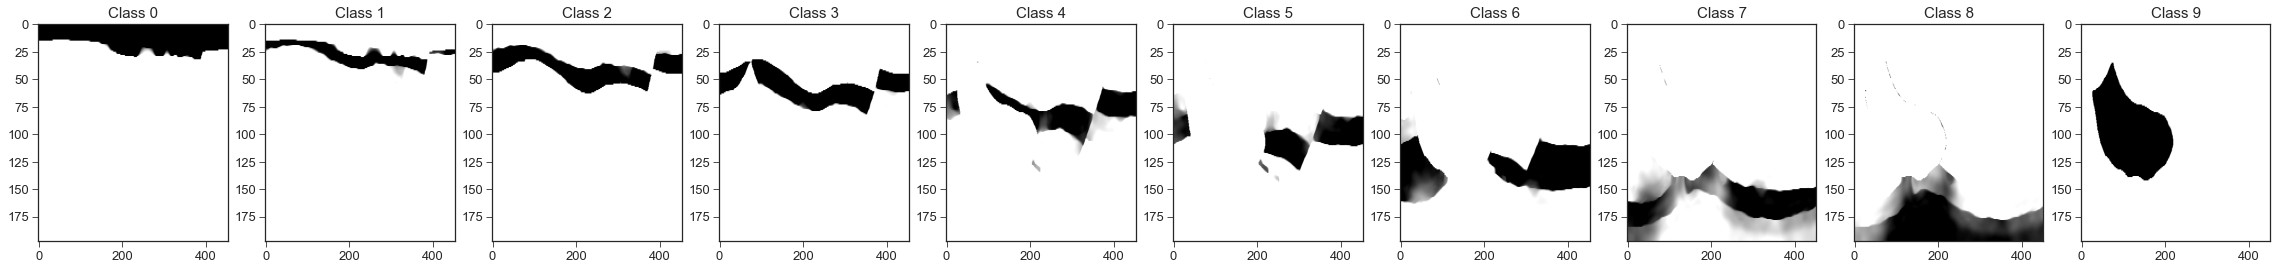

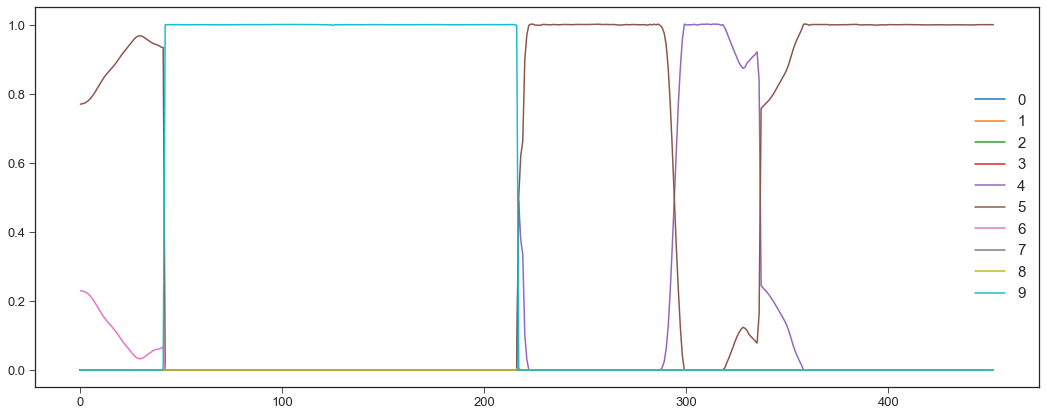

In [24]:
fig, axs = plt.subplots(1, ncl, figsize=(4*ncl, 4))
for icl in range(ncl):
    im = axs[icl].imshow(segpd[:, icl].reshape(nt0, nx), cmap='gray_r')
    axs[icl].set_title('Class %d' % icl)
    axs[icl].axis('tight')
       
plt.figure(figsize=(18, 7))
for icl in range(ncl):
    plt.plot(segpd.reshape(nt0, nx, ncl)[100, :, icl], label=icl)
plt.legend();

### Extract horizons

In [25]:
horizon_list_ls = multiclass_horizons(ncl, segls_classes, 
                                      nn_lim=1, line_minlen=5, 
                                      verbose=False)

In [26]:
horizon_list = multiclass_horizons(ncl, segpd_classes, 
                                   nn_lim=1, line_minlen=5, 
                                   verbose=False)

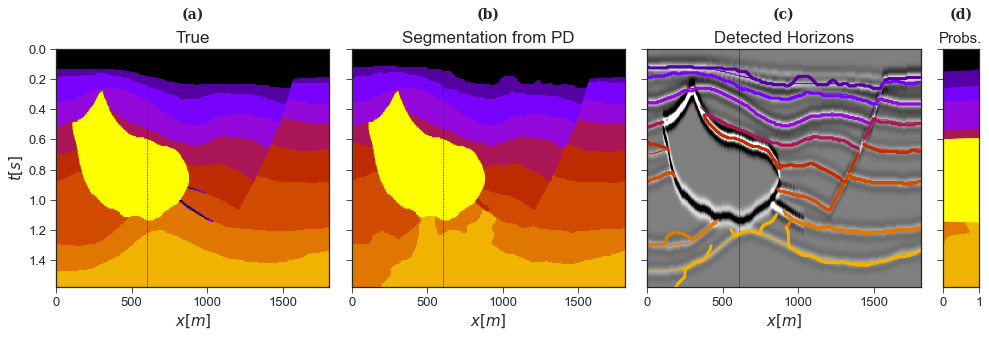

In [27]:
cmap_classes = 'gnuplot'
norm = Normalize(vmin=-0.5, vmax=ncl-0.5)

fig, axs = plt.subplots(1, 4, sharey=True, figsize=(14, 5),
                        gridspec_kw={'width_ratios': [3, 3, 3, 0.4]})
axs[0].imshow(vcl_true, cmap=cm.get_cmap(cmap_classes, ncl), vmin=-0.5, vmax=ncl-0.5,
              extent=(x[0], x[-1], t0[-1], t0[0]))
axs[0].axvline(x[nx//3], c='k', ls='--', lw=0.5)
axs[0].axis('tight')
axs[0].set_ylabel(r'$t [s]$')
axs[0].set_xlabel(r'$x [m]$')
axs[0].set_title('True', fontsize=17)
axs[0].text(0.5, 1.13, '(a)', ha='center', fontsize=14, fontweight='bold', 
            family='serif', transform=axs[0].transAxes)
axs[1].imshow(segpd_classes, cmap=cm.get_cmap(cmap_classes, ncl), vmin=-0.5, vmax=ncl-0.5,
              extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1].axvline(x[nx//3], c='k', ls='--', lw=0.5)
axs[1].axis('tight')
axs[1].set_xlabel(r'$x [m]$')
axs[1].set_title('Segmentation from PD', fontsize=17)
axs[1].text(0.5, 1.13, '(b)', ha='center', fontsize=14, fontweight='bold', 
            family='serif', transform=axs[1].transAxes)
axs[2].imshow(d, cmap='gray', vmin=-0.1, vmax=0.1, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[2].axvline(x[nx//3], c='k', ls='--', lw=0.5)
axs[2].axis('tight')
for ihor, horkey in enumerate(hors.keys()):
    axs[2].plot(np.arange(nx) * dx, hors[horkey]* dt0, 
                c=cm.get_cmap(cmap_classes, ncl)(norm(ihor+1)), lw=1)
for ihor, horkey in enumerate(hors.keys()):
        horsel = [h for i, h in horizon_list.iterrows() if h['chosen'] and h['h_id'] == horkey]
        for hsel in horsel:
            axs[2].plot(hsel['regx']* dx, hsel['regy']* dt0,
                        c=cm.get_cmap(cmap_classes, ncl)(norm(ihor+1)), lw=3)
axs[2].set_xlabel(r'$x [m]$')
axs[2].set_title('Detected Horizons', fontsize=17)
axs[2].text(0.5, 1.13, '(c)', ha='center', fontsize=14, fontweight='bold', 
            family='serif', transform=axs[2].transAxes)

norm = Normalize(vmin=0, vmax=ncl)
probs = segpd.reshape(nt0, nx, ncl)[:, nx//3]
cdf = np.cumsum(probs, axis=1)
cdf = np.hstack((np.zeros((nt0, 1)), cdf))
for icl in range(ncl):
    axs[3].fill_betweenx(t0, cdf[:, icl], cdf[:, icl+1], 
                         color=cm.get_cmap(cmap_classes, ncl)(norm(icl)))
axs[3].set_xlim(0, 1)
axs[3].set_title('Probs.')
axs[3].text(0.5, 1.13, '(d)', ha='center', fontsize=14, fontweight='bold', 
            family='serif', transform=axs[3].transAxes)
plt.tight_layout()
plt.savefig('Figs/Hess_segmentation.eps', dpi=80);

## 2D Post-stack joint inversion & segmentation

**Inversion**

$$
m^{k+1} = min_x  (\frac{1}{2}||Ax-f||_2^2 + \delta ||\hat{V}x-\hat{c}||_2^2 - \alpha p^{kT}x) + \alpha ||Dx||_{2,1} 
$$

combining the first two terms

$$
m^{k+1} = min_x  (\frac{1}{2}||A^1x-f^1||_2^2 - \alpha p^{kT}x) + \alpha ||Dx||_{2,1} 
$$

where $A^1 = [A, \sqrt{2\delta}\hat{V}]^T$ and $f^1 = [f, \sqrt{2\delta}\hat{c}]^T$ and $\hat{V}=[diag(\sqrt{v_1}), ..., diag(\sqrt{v_N})]$ and $\hat{c}=[\sqrt{v_1}c_1, ..., \sqrt{v_N}c_N]$


**Segmentation**


$$
v^{k+1} = min_{v \in C}  (v^T(\delta g - \beta q^k) - \alpha p^{kT}x) + \alpha ||Dx||_{2,1} 
$$

where $C$ is a simplex.

Working with alpha=0.010000,  beta=0.100000,  delta=2.000000
Iteration 0...
Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
Additional vector (z): None
tau = 1.000000e+00	mu = 1.237500e-01
theta = 1.00		niter = 100

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   1.61196e+01   1.914e+01   6.993e+00   0.000e+00       2.614e+01
     2   1.61259e+01   9.430e+00   8.270e+00   0.000e+00       1.770e+01
     3   1.61337e+01   6.373e+00   8.728e+00   0.000e+00       1.510e+01
     4   1.61418e+01   5.003e+00   8.837e+00   0.000e+00       1.384e+01
     5   1.61492e+01   4.239e+00   8.808e+00   0.000e+00       1.305e+01
     6   1.61555e+01   3.757e+00   8.726e+00   0.000e+00       1.248e+01
     7   1.61605e+01   3.426e+00 

     1   5.09162e-01   0.000e+00   9.751e+01   6.042e+03       6.140e+03
     2   6.74569e-01   0.000e+00   1.176e+02   3.526e+03       3.643e+03
     3   7.61842e-01   0.000e+00   1.309e+02   2.524e+03       2.655e+03
     4   8.49105e-01   0.000e+00   1.398e+02   1.966e+03       2.106e+03
     5   9.36354e-01   0.000e+00   1.466e+02   1.513e+03       1.659e+03
     6   1.00015e+00   0.000e+00   1.483e+02   1.216e+03       1.364e+03
     7   1.00143e+00   0.000e+00   1.492e+02   1.064e+03       1.213e+03
     8   9.98774e-01   0.000e+00   1.498e+02   9.648e+02       1.115e+03
     9   9.99988e-01   0.000e+00   1.512e+02   8.945e+02       1.046e+03
    10   1.00139e+00   0.000e+00   1.518e+02   8.391e+02       9.908e+02
    11   9.98087e-01   0.000e+00   1.522e+02   7.944e+02       9.465e+02
    16   1.00179e+00   0.000e+00   1.545e+02   6.603e+02       8.148e+02
    21   1.00147e+00   0.000e+00   1.584e+02   5.825e+02       7.408e+02
    26   9.99023e-01   0.000e+00   1.608e+02   5.28

     8   1.61197e+01   5.786e+01   7.574e+00   0.000e+00       6.543e+01
     9   1.61196e+01   5.787e+01   7.543e+00   0.000e+00       6.541e+01
    10   1.61196e+01   5.788e+01   7.515e+00   0.000e+00       6.539e+01
    11   1.61195e+01   5.789e+01   7.490e+00   0.000e+00       6.538e+01
    21   1.61191e+01   5.796e+01   7.324e+00   0.000e+00       6.529e+01
    31   1.61188e+01   5.800e+01   7.240e+00   0.000e+00       6.524e+01
    41   1.61185e+01   5.803e+01   7.192e+00   0.000e+00       6.522e+01
    51   1.61183e+01   5.805e+01   7.162e+00   0.000e+00       6.521e+01
    61   1.61182e+01   5.806e+01   7.143e+00   0.000e+00       6.520e+01
    71   1.61180e+01   5.807e+01   7.130e+00   0.000e+00       6.520e+01
    81   1.61179e+01   5.807e+01   7.121e+00   0.000e+00       6.519e+01
    91   1.61178e+01   5.807e+01   7.115e+00   0.000e+00       6.519e+01
    92   1.61178e+01   5.807e+01   7.115e+00   0.000e+00       6.519e+01
    93   1.61178e+01   5.807e+01   7.114e+00   0.00

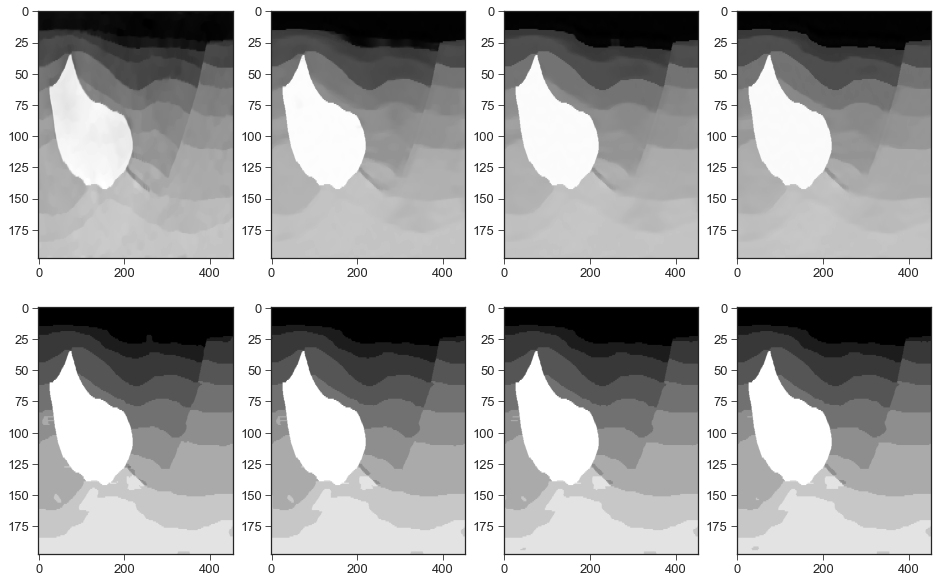

In [28]:
alpha = 0.01
beta = 0.1
delta = 2.

niter = 2
tolstop = 0.

L = 8. # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = 0.99 / (tau * L)

mjoint, vjoint, vcljoint, rre_j, psnr_j, mjoint_hist, vjoint_hist = \
    joint_inversion_segmentation(dn, mback, cl, Lop, alpha, beta, delta, tau, mu,
                                 niter=4, l2niter=20, pdniter=100,
                                 segmentniter=50, bisectniter=10, tolstop=0.,
                                 mtrue=m, plotflag=True, show=True)

[ 9999978. 12747960. 13921967. 16351979. 17993972. 19145972. 20859960.
 22355962. 23755936. 29599952.]


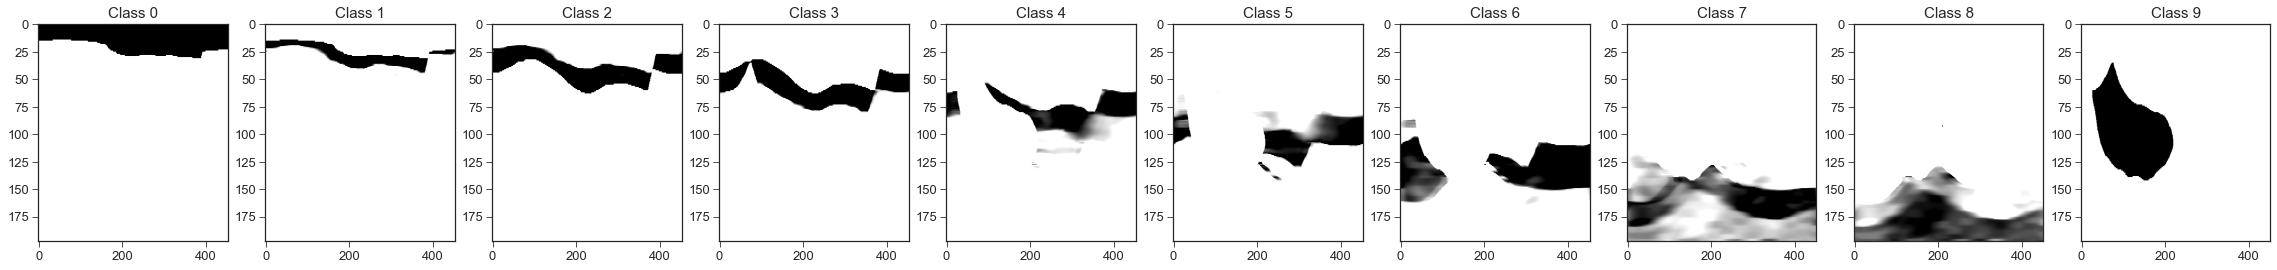

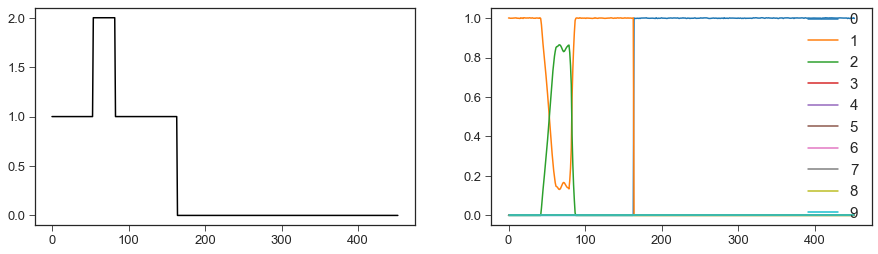

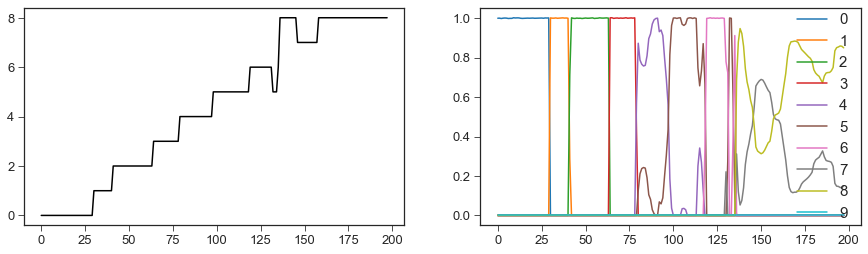

In [29]:
fig, axs = plt.subplots(1, ncl, figsize=(4*ncl, 4))
for icl in range(ncl):
    im = axs[icl].imshow(vjoint[:, icl].reshape(nt0, nx), cmap='gray_r')
    axs[icl].set_title('Class %d' % icl)
    axs[icl].axis('tight')
    
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(vcljoint.reshape(nt0, nx)[20], 'k')
for icl in range(ncl):
    axs[1].plot(vjoint.reshape(nt0, nx, ncl)[20, :, icl], label=icl)
axs[1].legend(loc='right')

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(vcljoint.reshape(nt0, nx)[:, nx//2], 'k')
for icl in range(ncl):
    axs[1].plot(vjoint.reshape(nt0, nx, ncl)[:, nx//2, icl], label=icl)
axs[1].legend(loc='right');

print(np.exp(cl))

Text(0.5, 0, '#Outer Iteration')

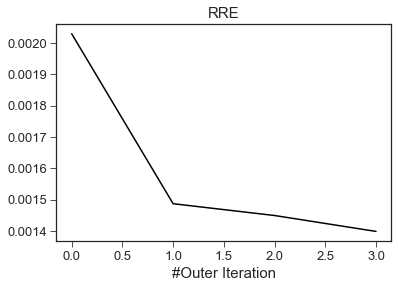

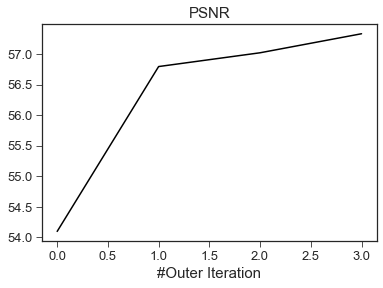

In [30]:
plt.figure()
plt.plot(rre_j, 'k')
plt.title('RRE')
plt.xlabel('#Outer Iteration')

plt.figure()
plt.plot(psnr_j, 'k')
plt.title('PSNR')
plt.xlabel('#Outer Iteration')

In [31]:
horizon_list_joint = multiclass_horizons(ncl, vcljoint.reshape(nt0, nx), 
                                         nn_lim=1, line_minlen=5, 
                                         verbose=True)

Class: 0
Start: 2021-07-05 14:30:44.502040
Compute TV Completed: 0:00:00.010218 sec
Get horizon points Completed: 0:00:00.000666 sec
Get separated horizons Completed: 0:00:03.371514 sec
Interpolate horizons Completed: 0:00:00.000845 sec
Label horizons Completed: 0:00:00.003804 sec
Join horizons Completed: 0:00:00.007752 sec
Regredding horizons Completed: 0:00:00.001434 sec
End: 2021-07-05 14:30:47.899143
Duration: 0:00:03.397103
 
Class: 1
Start: 2021-07-05 14:30:47.899190
Compute TV Completed: 0:00:00.003967 sec
Get horizon points Completed: 0:00:00.000270 sec
Get separated horizons Completed: 0:00:05.224508 sec
Interpolate horizons Completed: 0:00:00.000907 sec
Label horizons Completed: 0:00:00.003730 sec
Join horizons Completed: 0:00:00.009102 sec
Regredding horizons Completed: 0:00:00.003226 sec
End: 2021-07-05 14:30:53.145889
Duration: 0:00:05.246699
 
Class: 2
Start: 2021-07-05 14:30:53.145942
Compute TV Completed: 0:00:00.004066 sec
Get horizon points Completed: 0:00:00.000516 s

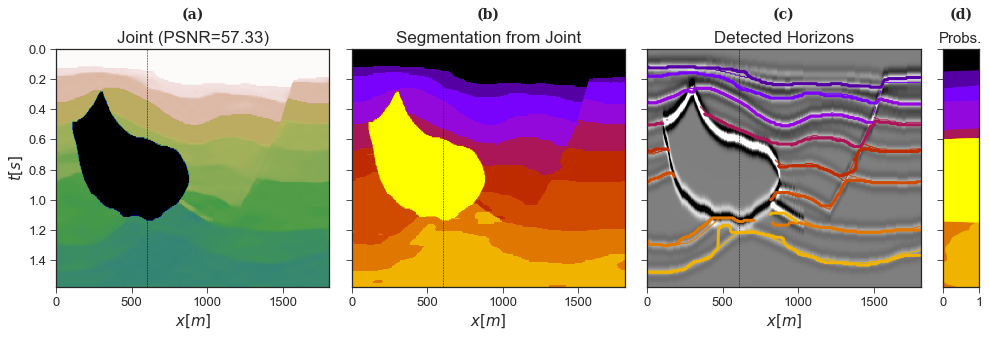

In [32]:
cmap_classes = 'gnuplot'
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(14, 5),
                        gridspec_kw={'width_ratios': [3, 3, 3, 0.4]})
axs[0].imshow(np.exp(mjoint).reshape(nt0, nx), vmin=1.2e7, vmax=2.9e7,
                   cmap='gist_earth_r', extent=(x[0], x[-1], t0[-1], t0[0]))
axs[0].axvline(x[nx//3], c='k', ls='--', lw=0.5)
axs[0].axis('tight')
axs[0].set_ylabel(r'$t [s]$')
axs[0].set_xlabel(r'$x [m]$')
axs[0].set_title(r'Joint (PSNR=%.2f)' % psnr_j[-1], fontsize=17)
axs[0].text(0.5, 1.13, '(a)', ha='center', fontsize=14, fontweight='bold', 
            family='serif', transform=axs[0].transAxes)

axs[1].imshow(vcljoint.reshape(nt0, nx), cmap=cm.get_cmap(cmap_classes, ncl), vmin=-0.5, vmax=ncl-0.5,
              extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1].axvline(x[nx//3], c='k', ls='--', lw=0.5)
axs[1].axis('tight')
axs[1].set_xlabel(r'$x [m]$')
axs[1].set_title('Segmentation from Joint', fontsize=17)
axs[1].text(0.5, 1.13, '(b)', ha='center', fontsize=14, fontweight='bold', 
            family='serif', transform=axs[1].transAxes)
axs[2].imshow(d, cmap='gray', vmin=-0.1, vmax=0.1, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[2].axvline(x[nx//3], c='k', ls='--', lw=0.5)
axs[2].axis('tight')
for ihor, horkey in enumerate(hors.keys()):
    axs[2].plot(np.arange(nx) * dx, hors[horkey]* dt0, 
                c=cm.get_cmap(cmap_classes, ncl)(norm(ihor+1)), lw=1)
for ihor, horkey in enumerate(hors.keys()):
        horsel = [h for i, h in horizon_list_joint.iterrows() if h['chosen'] and h['h_id'] == horkey]
        for hsel in horsel:
            axs[2].plot(hsel['regx']* dx, hsel['regy']* dt0,
                        c=cm.get_cmap(cmap_classes, ncl)(norm(ihor+1)), lw=3)
axs[2].set_xlabel(r'$x [m]$')
axs[2].set_title('Detected Horizons', fontsize=17)
axs[2].text(0.5, 1.13, '(c)', ha='center', fontsize=14, fontweight='bold', 
            family='serif', transform=axs[2].transAxes)

norm = Normalize(vmin=0, vmax=ncl)
probs = vjoint.reshape(nt0, nx, ncl)[:, nx//3]
cdf = np.cumsum(probs, axis=1)
cdf = np.hstack((np.zeros((nt0, 1)), cdf))
for icl in range(ncl):
    axs[3].fill_betweenx(t0, cdf[:, icl], cdf[:, icl+1], 
                         color=cm.get_cmap(cmap_classes, ncl)(norm(icl)))
axs[3].set_xlim(0, 1)
axs[3].set_title('Probs.')
axs[3].text(0.5, 1.13, '(d)', ha='center', fontsize=14, fontweight='bold', 
            family='serif', transform=axs[3].transAxes)
plt.tight_layout()
plt.savefig('Figs/Hess_joint.eps', dpi=80);

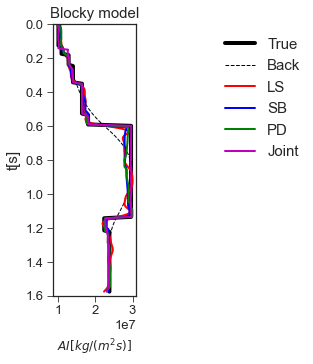

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(1.5, 5))
ax.plot(np.exp(m[:, nx//3]), t0, 'k', lw=4, label='True')
ax.plot(np.exp(mback[:, nx//3]), t0, '--k', lw=1, label='Back')
ax.plot(np.exp(minv[:, nx//3]), t0, 'r', lw=2, label='LS')
ax.plot(np.exp(mladmm[:, nx//3]), t0, 'b', lw=2, label='SB')
ax.plot(np.exp(mpd[:, nx//3]), t0, 'g', lw=2, label='PD')
ax.plot(np.exp(mjoint).reshape(nt0, nx)[:, nx//3], t0, 'm', lw=2, label='Joint')
ax.set_xlabel(r'$AI [kg/(m^2s)]$', fontsize=12, labelpad=20.)
ax.set_ylabel('t[s]')
ax.set_title('Blocky model')
ax.set_ylim(1.6, 0)
ax.legend(bbox_to_anchor=(1.9, 1.))
plt.savefig('Figs/Hess_traces.eps', dpi=150, bbox_inches='tight');

Finally we want to assess the uncertainties in our horizon estimations using the TV of the different class probabilities

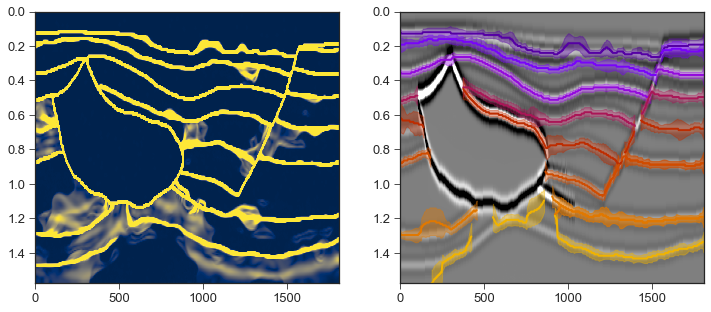

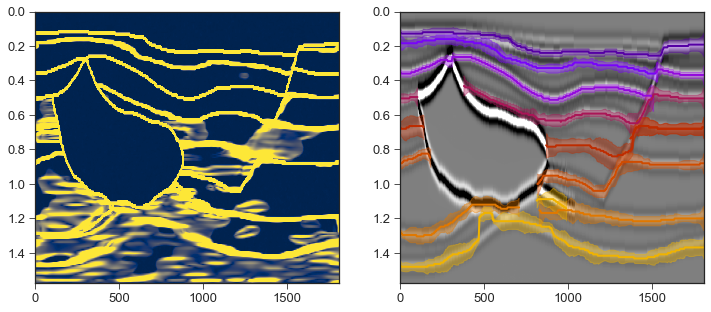

In [34]:
# Serial
hors_unc, tv_tot_plot = uncertainty_horizons(segpd.reshape(nt0, nx, ncl), horizon_list, list(hors.keys()))

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(tv_tot_plot, vmin=0, vmax=0.1, cmap='cividis', 
          extent=(x[0], x[-1], t0[-1], t0[0]))
axs[0].axis('tight')
axs[1].imshow(d, cmap='gray', vmin=-0.1, vmax=0.1, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1].axis('tight')

for ihor, horkey in enumerate(hors.keys()):
    horsel = [h for i, h in horizon_list.iterrows() if h['chosen'] and h['h_id'] == horkey]
    for ihsel, hsel in enumerate(horsel):
        axs[1].fill_between(hsel['regx'] * dx, 
                        hsel['regy'] * dt0 -10 * hors_unc[horkey][ihsel] * dt0, 
                        hsel['regy'] * dt0 +10 * hors_unc[horkey][ihsel] * dt0, 
                        alpha=.4, color=cm.get_cmap(cmap_classes, ncl)(norm(ihor+1)))#'#FFEC2A'
        axs[1].plot(hsel['regx']* dx, hsel['regy']* dt0, lw=2,
                    c=cm.get_cmap(cmap_classes, ncl)(norm(ihor+1)))#'#FFEC2A'
ax.set_xlabel(r'$x [m]$')
ax.set_title('Horizon uncertainties')

# Joint
hors_unc, tv_tot_plot = uncertainty_horizons(vjoint.reshape(nt0, nx, ncl), horizon_list_joint, list(hors.keys()))

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(tv_tot_plot, vmin=0, vmax=0.1, cmap='cividis', 
          extent=(x[0], x[-1], t0[-1], t0[0]))
axs[0].axis('tight')
axs[1].imshow(d, cmap='gray', vmin=-0.1, vmax=0.1, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1].axis('tight')

for ihor, horkey in enumerate(hors.keys()):
    horsel = [h for i, h in horizon_list_joint.iterrows() if h['chosen'] and h['h_id'] == horkey]
    for ihsel, hsel in enumerate(horsel):
        axs[1].fill_between(hsel['regx'] * dx, 
                        hsel['regy'] * dt0 -10 * hors_unc[horkey][ihsel] * dt0, 
                        hsel['regy'] * dt0 +10 * hors_unc[horkey][ihsel] * dt0, 
                        alpha=.4, color=cm.get_cmap(cmap_classes, ncl)(norm(ihor+1)))#'#FFEC2A'
        axs[1].plot(hsel['regx']* dx, hsel['regy']* dt0, lw=2,
                    c=cm.get_cmap(cmap_classes, ncl)(norm(ihor+1)))#'#FFEC2A'
ax.set_xlabel(r'$x [m]$')
ax.set_title('Horizon uncertainties');

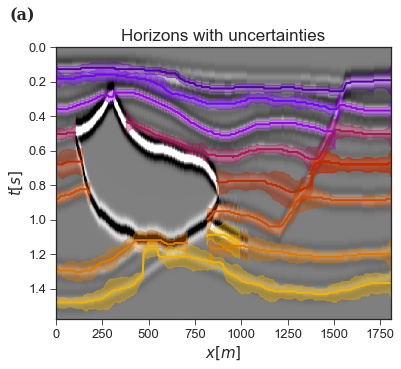

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.imshow(d, cmap='gray', vmin=-0.1, vmax=0.1, extent=(x[0], x[-1], t0[-1], t0[0]))
ax.axis('tight')

for ihor, horkey in enumerate(hors.keys()):
    horsel = [h for i, h in horizon_list_joint.iterrows() if h['chosen'] and h['h_id'] == horkey]
    for ihsel, hsel in enumerate(horsel):
        ax.fill_between(hsel['regx'] * dx, 
                        hsel['regy'] * dt0 -12 * hors_unc[horkey][ihsel] * dt0, 
                        hsel['regy'] * dt0 +12 * hors_unc[horkey][ihsel] * dt0, 
                        alpha=.4, color=cm.get_cmap(cmap_classes, ncl)(norm(ihor+1)))#'#FFEC2A'
        ax.plot(hsel['regx']* dx, hsel['regy']* dt0, lw=2,
                    c=cm.get_cmap(cmap_classes, ncl)(norm(ihor+1)))#'#FFEC2A'
ax.text(-0.1, 1.1, '(a)', ha='center', fontsize=16, fontweight='bold', 
        family='serif', transform=ax.transAxes)
ax.axis('tight')
ax.set_ylabel(r'$t [s]$')
ax.set_xlabel(r'$x [m]$')
ax.set_title('True')
ax.set_xlabel(r'$x [m]$')
ax.set_title('Horizons with uncertainties', fontsize=17);
plt.savefig('Figs/Hess_uncertainty.png', dpi=200);